In [1]:
muacamuaca=open("../CriterioFranco/DatosActividadEpilepticaSelectos.bin", "r")

IOStream(<file ../CriterioFranco/DatosActividadEpilepticaSelectos.bin>)

In [2]:
formaarray=(64,64,9101)

(64,64,9101)

In [3]:
Datos=read(muacamuaca, Float64, formaarray);

In [4]:
tmax=formaarray[3]


9101

In [5]:
function umbral(x)
    result=((abs(x)>250) ? 0 : x)
end;

function aplastar(x)
    result=((abs(x)<60) ? 0 : x)
end;

function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

UnNormGauss (generic function with 1 method)

In [6]:
close(muacamuaca)


In [7]:
Mascara=readdlm("Parchada02.dat");

In [8]:
function GaussSuavizar(Datos,Sigma)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3 sigmas.
    #Bien, veamos como chingaos le ponemos "padding" a las convoluciones.
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), [-medioancho:medioancho])
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #result=result*a/b
    return result
end
    

GaussSuavizar (generic function with 1 method)

In [9]:
ParteInteresante=Datos[:,:,3000:8000]
formaarray=size(ParteInteresante)
tmax=formaarray[3]

5001

In [10]:
DatosLimpios=zeros(formaarray)
for t=1:tmax
    DatosLimpios[:,:,t]=ParteInteresante[:,:,t].*Mascara
end

In [11]:
map!(aplastar, DatosLimpios);
map!(umbral, DatosLimpios);

In [12]:
Chumbaganga=zeros(formaarray);
for j=1:64, k=1:64
    if(Mascara[j,k]==1)
   #     Chumbaganga[j,k,:]=GaussSuavizar(reshape(CuernoDeAmon[j,k,:],tmax),7)
        Chumbaganga[j,k,:]=GaussSuavizar(reshape(DatosLimpios[j,k,:],tmax),7)
    end    
end

In [16]:
writedlm("ExampleDatosLargosSuaves-55-49.dat", reshape(Chumbaganga[49,55,:],tmax))

In [13]:
GaussianKernel=readdlm("GaussianMatrixFilter01.dat");
function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #piensa como normalizar
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [14]:
Sumbaganga=zeros(formaarray)
for t=1:tmax
    Sumbaganga[:,:,t]=GaussianSmooth(Chumbaganga[:,:,t])
end


In [15]:
extrema(Sumbaganga)

(-177.40269703504885,184.53240220268867)

In [16]:
extrema(abs(Sumbaganga))

(0.0,184.53240220268867)

In [17]:
mean(abs(Sumbaganga))

1.0693069435882294

In [20]:
Datos=0



0

In [19]:
gc()

In [24]:
# a escribir, pa variar
for t=1:tmax
#    aux=map(x-> isnan(x)?0:x, Chumbaganga[:,:,t])
    zacatlan="GarbageCollector/GaussianFilteredSpaceTime-$t.dat"
    writedlm(zacatlan, Sumbaganga[:,:,t])
end

In [21]:
LaplacianKernel=zeros(3,3);
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianKernel=[[0.5 1. 0.5], [1. -6. 1], [0.5 1. 0.5]];

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo, k=2:ancho
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end

DiscreteLaplacian (generic function with 1 method)

Vamos a hacer una interpolación de los datos, a fin de que el Laplaciano tenga un efecto mas de borde y no tan violento en los picos.

In [22]:
using Grid

In [23]:
MuestraGauss=Sumbaganga[:,:,2567];

In [24]:
using PyPlot

INFO: Loading help data...


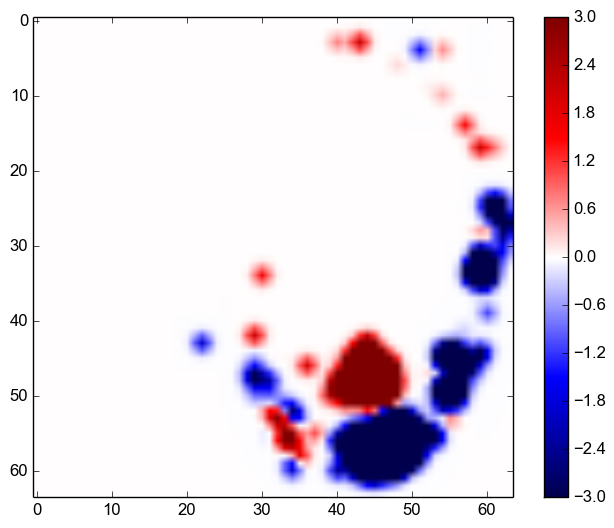

PyObject <matplotlib.colorbar.Colorbar instance at 0x7fe7c72c80e0>

In [25]:
imshow(MuestraGauss, cmap="seismic", vmin=-3, vmax=3)
colorbar()

Esa muestra es en realidad sin interpolar, quien realmente esta interpolando es el mugroso matplotlib. Por eso parecen "suaves" los datos.

In [27]:
#Okey, vamos a ponerle galleta a esto: los primeros 1500 frames estan muy aburridos. Creo que podemos tirarlos a la basura.
Laplaganga=zeros(256,256,tmax)
x=1:64
y=1:64
for t=1:tmax
    cuaracuaca = CoordInterpGrid((x,y), Sumbaganga[:,:,t], BCreflect, InterpQuadratic);
    MuestraDensificada=zeros(256,256)
    for j=4:256, k=4:256
        MuestraDensificada[j,k]=cuaracuaca[j/4.0, k/4.0]
    end
    Laplaganga[:,:,t]=MuestraDensificada

end

In [28]:
gc()

In [29]:
for t=1:5001
    Laplaganga[:,:,t]=DiscreteLaplacian(Laplaganga[:,:,t])
end

In [30]:
extrema(Laplaganga)

(-106.74669493582535,117.68386301932263)

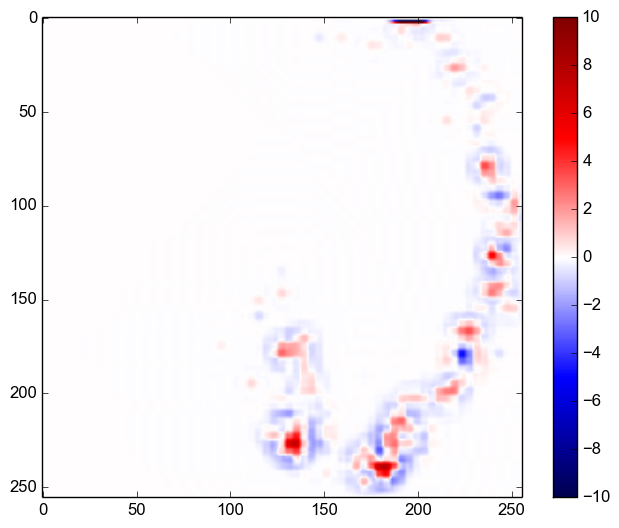

PyObject <matplotlib.colorbar.Colorbar instance at 0x7fe793d7bc20>

In [32]:
Tururu=Laplaganga[:,:,1999];
imshow(Tururu, cmap="seismic", vmin=-10, vmax=10)
colorbar()

In [33]:
for t=1:5001
#    aux=map(x-> isnan(x)?0:x, Chumbaganga[:,:,t])
    zacatlan="GarbageCollector/LaplacianFilteredSpaceTime-$t.dat"
    writedlm(zacatlan, Laplaganga[:,:,t])
end


In [65]:
ActividadNegativa=zeros(Laplaganga);
ActividadPositiva=zeros(Laplaganga);
SpikeCountPositivo=zeros(64,64);
SpikeCountNegativo=zeros(64,64);
SpikeCountTotal=zeros(64,64;)
for j=1:64
    for k=1:64
        for t=1:tmax          
            if(Laplaganga[j,k,t]<-0.0)      
                ActividadNegativa[j,k,t]=Laplaganga[j,k,t]
                SpikeCountNegativo[j,k]+=1
            elseif(Laplaganga[j,k,t]>0.0) 
                ActividadPositiva[j,k,t]=Laplaganga[j,k,t]
                SpikeCountPositivo[j,k]+=1
            end
        end
            
    end
end


In [66]:
writedlm("SpikeCountNegativo.dat", SpikeCountNegativo)
writedlm("SpikeCountPositivo.dat", SpikeCountPositivo)

In [68]:
Salida=open("DatosCMNegativo01.dat", "w");
(xanterior, yanterior)=(32., 32.)
for t=1:tmax
    masa=sum(ActividadNegativa[:,:,t]);
    xmasa=0.0
    ymasa=0.0
    for j=1:64
        xmasa+=j*sum(ActividadNegativa[j,:,t])
        ymasa+=j*sum(ActividadNegativa[:,j,t])
    end
    if(abs(masa)>50)
        xmasa=-xmasa/masa
        ymasa=-ymasa/masa
        write(Salida,join((xmasa,ymasa,masa), "\t"), "\n" )
        xanterior=xmasa
        yanterior=ymasa
    else
        write(Salida,join((xanterior,yanterior,0.0), "\t"), "\n" )
    end
end
close(Salida);


In [69]:
Salida=open("DatosCMPositivo01.dat", "w")
(xanterior,yanterior)=(32.0, 32.0)
for t=1:tmax
    masa=sum(ActividadPositiva[:,:,t]);
    xmasa=0.0
    ymasa=0.0
    for j=1:64
        xmasa+=j*sum(ActividadPositiva[j,:,t])
        ymasa+=j*sum(ActividadPositiva[:,j,t])
    end
    if(abs(masa)>50)
        xmasa=xmasa/masa
        ymasa=ymasa/masa
        write(Salida,join((xmasa,ymasa,masa), "\t"), "\n" )
        xanterior=xmasa
        yanteriro=ymasa
    else 
        write(Salida,join((xanterior,yanterior,0.0), "\t"), "\n" )
    end
        
end
close(Salida);